In [444]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv
import requests

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error


In [445]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')

In [446]:
data_all = pd.read_csv('data/01_datawrangling_byzcta_out.csv', index_col=0)

data_all.head()

zcta_freq_floods = data_all.loc[data_all['nflood_total'] > 40, 'zcta']
zcta_freq_floods
data_all.index = data_all['zcta']
data_all.head()
data_all.dtypes

med_houseinc_12mon                        float64
household_public_assistance1              float64
state_fips                                  int64
nflood_total                                int64
flood_count_fall                            int64
flood_count_winter                          int64
flood_count_spring                          int64
nflood_2000s                              float64
nflood_2010s                              float64
flood_dur_hours_median                    float64
flood_dur_hours_min                       float64
flood_dur_hours_max                       float64
zcta                                        int64
med_houseinc_12mon_state_med              float64
household_public_assistance1_state_med    float64
dtype: object

In [559]:
##define census data variables to pull, and the data label
# variables: https://api.census.gov/data/2022/acs/acs5/variables.html

fields_dict = {'NAME': 'Name',
               # 'B19081_001E': 'houseinc_1',
               # 'B19081_002E': 'houseinc_2',
               # 'B19081_003E': 'houseinc_3',
               # 'B19081_004E': 'houseinc_4',
               # 'B19081_005E': 'houseinc_5',
               # 'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1', 
               'B19083_001E': 'gini',
               'B19081_001E': 'total_population',
               'B01001_002E': 'total_male', 
               'B01001_026E': 'total_female', 
               'B08303_001E': 'total_travel_time_to_work', 
               'B25105_001E': 'median_monthly_housing_costs', 
               
               'B25104_001E': 'total_monthlyHousingCosts', 
               'B25104_002E': 'total_HousingCosts_lessThan100', 
               # 'B25104_003E': 'total_HousingCosts_100To199', 
               # 'B25104_004E': 'total_HousingCosts_200To299', 
               # 'B25104_005E': 'total_HousingCosts_300TO399', 
               # 'B25104_006E': 'total_HousingCosts_400To499', 
               'B25104_007E': 'total_HousingCosts_500To599', 
               # 'B25104_008E': 'total_HousingCosts_600To699', 
               # 'B25104_009E': 'total_HousingCosts_700To799', 
               # 'B25104_010E': 'total_HousingCosts_800To899', 
               # 'B25104_011E': 'total_HousingCosts_900To999', 
               'B25104_012E': 'total_HousingCosts_1000To1499', 
               'B25104_013E': 'total_HousingCosts_1500To1999', 
               'B25104_014E': 'total_HousingCosts_2000To2499', 
               'B25104_015E': 'total_HousingCosts_2500To2999', 
               'B25104_016E': 'total_HousingCosts_3000OrMore', 
               # 'B25104_017E': 'total_HousingCosts_noCashRent', 
               
               'B01002_002E': 'median_age_male', 
               'B01002_003E': 'median_age_female', 
               
               # 'B15002_003E': 'education_noSchoolCompleted_maleOver25', 
               # 'B15002_020E': 'education_noSchoolCompleted_femaleOver25', 

               'B15003_017E': 'education_regularHSDiploma_over25',
               'B15003_018E': 'education_GEDAlt_over25',
               'B15003_019E': 'education_someCollegeLessThan1Yr_over25',
               'B15003_020E': 'education_someCollegeMoreThan1YrNoDegree_over25',
               'B15003_021E': 'education_associatesDegree_over25',
               'B15003_022E': 'education_BachelorsDegree_over25',
               'B15003_023E': 'education_mastersDegree_over25', 
               'B15003_024E': 'education_professionalSchoolDegree_over25', 
               'B15003_025E': 'education_doctorateDegree_over25', 

               'B18101_001E': 'male_35-64_withdisability',
               'B18101_032E': 'female_35-64_withdisability',
               'C16002_002E': 'householdLanguage_englishOnly', 
               'C16002_004E': 'householdLanguage_SpanishLimitedEnglish',
               'C16002_005E': 'householdLanguage_SpanishNotLimitedEnglish', 
               
               'C24050_002E': 'industry_agForestryEtc', 
               'C24050_003E': 'industry_construction', 
               'C24050_004E': 'industry_manufacturing', 
               'C24050_005E': 'industry_wholesaleTrade', 
               'C24050_006E': 'industry_retailTrade', 
               'C24050_007E': 'industry_transportationWarehousingUtilities', 
               'C24050_008E': 'industry_information', 
               'C24050_009E': 'industry_financeInsuranceRealEstate', 
               'C24050_010E': 'industry_professionalScientificManagementEtc', 
               'C24050_011E': 'industry_educationHealcareSocialAssistance', 
               'C24050_012E': 'industry_artsEntertainmentRecreationAccommodation',
               'C24050_013E': 'industry_otherServices', 
               'C24050_014E': 'industry_publicAdmin', 
               'C24050_015E': 'industry_managementBusinessScienceArts' 
              }

fields = ','.join(list(fields_dict.keys()))
# names = list(fields_dict.values()) + ['zcta']
names = list(fields_dict.values()) + ['state', 'county', 'tract']


In [565]:
r_test.text

'error: unknown/unsupported geography heirarchy'

In [564]:
### request data from api, put into dataframe
# geography exameples: https://api.census.gov/data/2020/acs/acs5/examples.html
# url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=zip%20code%20tabulation%20area:*&key=' + API_KEY
# url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=tract:*&in=state:06 county:*&key=' + API_KEY
url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=tract:*&key=' + API_KEY


r_test = requests.get(url)
# r_test.json()
df_census = pd.DataFrame(r_test.json()[1::], columns=names)


# df_census.index = df_census['zcta'].astype('int')
# df_census.drop(['zcta', 'Name'], inplace=True, axis=1)

df_census.head()


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [536]:
df_census = df_census.apply(pd.to_numeric, errors='ignore')

df_census.replace(-666666666, np.nan, inplace=True)
df_census['med_houseinc_12mon'] = df_census['med_houseinc_12mon'].replace(250000, np.nan) ## drop income = 250000; actually 250000 and higher
df_census.dropna(inplace=True)
df_census.isna().sum()
# df_census.dtypes

/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_92390/1806658217.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_census = df_census.apply(pd.to_numeric, errors='ignore')


med_houseinc_12mon                                   0
household_public_assistance1                         0
gini                                                 0
total_population                                     0
total_male                                           0
total_female                                         0
total_travel_time_to_work                            0
median_monthly_housing_costs                         0
total_monthlyHousingCosts                            0
total_HousingCosts_lessThan100                       0
total_HousingCosts_500To599                          0
total_HousingCosts_1000To1499                        0
total_HousingCosts_1500To1999                        0
total_HousingCosts_2000To2499                        0
total_HousingCosts_2500To2999                        0
total_HousingCosts_3000OrMore                        0
median_age_male                                      0
median_age_female                                    0
education_

In [537]:
df_census_predict = df_census.copy()
df_census_predict.index = np.int64(df_census_predict.index)
df_census_predict = pd.concat([df_census_predict, data_all[['nflood_total', 'zcta']]], axis=1, join='outer')
# df_census_predict.dropna(inplace=True)

display(data_all.shape, df_census_predict.shape)
df_census_predict


(30351, 15)

(30585, 48)

,med_houseinc_12mon,household_public_assistance1,gini,total_population,total_male,total_female,total_travel_time_to_work,median_monthly_housing_costs,total_monthlyHousingCosts,total_HousingCosts_lessThan100,...,industry_information,industry_financeInsuranceRealEstate,industry_professionalScientificManagementEtc,industry_educationHealcareSocialAssistance,industry_artsEntertainmentRecreationAccommodation,industry_otherServices,industry_publicAdmin,industry_managementBusinessScienceArts,nflood_total,zcta
601,17526.0,5341.0,0.4530,3852.0,8337.0,8497.0,4414.0,165.0,5341.0,1280.0,...,17.0,258.0,461.0,1161.0,320.0,311.0,444.0,1153.0,NaN,NaN
602,20260.0,12777.0,0.4747,4160.0,18405.0,19237.0,10125.0,176.0,12777.0,2198.0,...,85.0,349.0,1276.0,1958.0,1091.0,982.0,586.0,2545.0,NaN,NaN
603,17703.0,19624.0,0.5630,1427.0,23813.0,25262.0,11917.0,270.0,19624.0,1876.0,...,121.0,429.0,1645.0,2653.0,1356.0,783.0,1505.0,4173.0,NaN,NaN
606,19603.0,1948.0,0.4447,2967.0,2723.0,2867.0,1335.0,129.0,1948.0,576.0,...,0.0,0.0,35.0,285.0,116.0,1.0,145.0,128.0,NaN,NaN
610,22796.0,8781.0,0.4643,5104.0,12317.0,13225.0,8307.0,208.0,8781.0,1263.0,...,106.0,215.0,941.0,2085.0,984.0,391.0,655.0,1935.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,99791.0
99832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,99832.0
99836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,99836.0
99918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,99918.0


In [538]:
# split test/train data
target = 'med_houseinc_12mon'
X = df_census.drop(target, axis=1)
y = df_census[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# y_train = np.log(y_train)
y_train



zcta
7202     63032.0
13849    55795.0
70719    89375.0
5086     76000.0
64076    83591.0
          ...   
16865    75000.0
32503    64857.0
74651    69219.0
61071    55478.0
58078    97231.0
Name: med_houseinc_12mon, Length: 19716, dtype: float64

In [539]:
rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)

rfr.fit(X_train, y_train)
print('training model score: ', rfr.score(X_train, y_train))
print('test model score: ', rfr.score(X_test, y_test))
y_pred_test = rfr.predict(X_test)
y_pred_train = rfr.predict(X_train)



training model score:  0.8721548816187524
test model score:  0.8675878433597314


In [540]:
# df_census_predict = pd.merge(df_census, pd.DataFrame(y_pred_test, index=y_test.index), how='outer', right_index=True, left_index=True)
# df_census_predict = pd.merge(df_census_predict, pd.DataFrame(y_pred_train, index=y_train.index), how='outer', right_index=True, left_index=True)

df_census_predict.loc[y_train.index, 'prediction_rfr'] = y_pred_train
df_census_predict.loc[y_test.index, 'prediction_rfr'] = y_pred_test

# zcta_freq_floods

<Axes: >

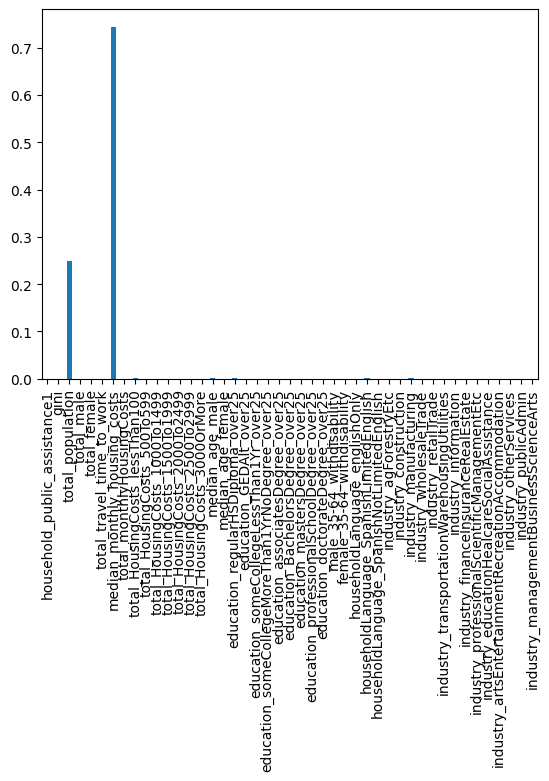

In [541]:
#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)




MSE:  123482754.58716261


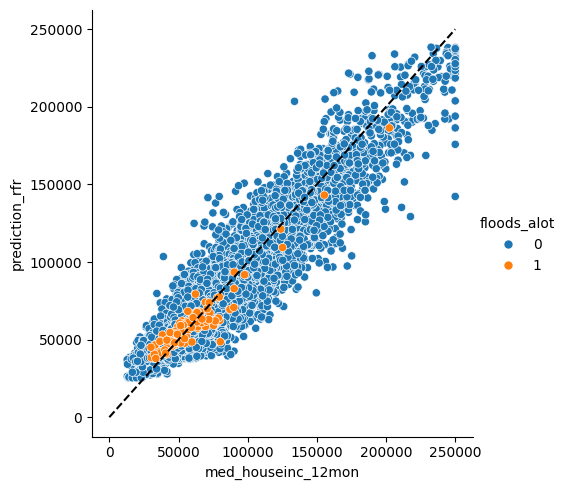

In [542]:
df_census_predict['floods_alot'] = 0
df_census_predict.loc[df_census_predict.index.isin(zcta_freq_floods), 'floods_alot'] = 1
sns.relplot(data=df_census_predict.sort_values('floods_alot'), x=target, y='prediction_rfr', hue='floods_alot')
# sns.relplot(data=df_census_predict.loc[df_census_predict['floods_alot']==1, :], x='med_houseinc_12mon', y='prediction', ax=ax)

# plt.plot([0.25, 0.75], [0.25, 0.75], linestyle='--', color='k')
plt.plot([0, 250000], [0, 250000], linestyle='--', color='k')
print('MSE: ', mean_squared_error(y_test, y_pred_test))

## Neural Net

In [543]:
# split test/train data
s_scaler = MinMaxScaler()
s_scaler.set_output(transform='pandas')

p_scaler = PowerTransformer()
s_scaler.set_output(transform='pandas')

scaler_pipe_x = Pipeline(steps=[('scale', s_scaler),
                              ('power', p_scaler)])
scaler_pipe_x.set_output(transform='pandas')

scaler_pipe_y = Pipeline(steps=[('scale', s_scaler),
                              ('power', p_scaler)])
scaler_pipe_y.set_output(transform='pandas')

# target = 'med_houseinc_12mon'

# split test/train data
X = df_census.drop(target, axis=1)
y = df_census[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

X_train = scaler_pipe_x.fit_transform(X_train)
X_test = scaler_pipe_x.transform(X_test)

y_train = scaler_pipe_y.fit_transform(y_train)
y_test = scaler_pipe_y.transform(y_test)

In [544]:
model = Sequential()
n_col = len(X_train.columns)
model.add(Dense(200, activation='linear', input_shape=(n_col,)))
model.add(Dense(200, activation='relu', input_shape=(n_col,)))
# model.add(Dense(200, activation='relu', input_shape=(n_col,)))

model.add(Dense(1))
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
  1/617 ━━━━━━━━━━━━━━━━━━━━ 1:11 116ms/step - loss: 1.2652

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.2174
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.1352
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.1286
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.1247
Epoch 5/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.1201
Epoch 6/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.1205
Epoch 7/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.1150
Epoch 8/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.1147
Epoch 9/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.1136
Epoch 10/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 0.1135


In [545]:
y_pred_test = model.predict(X_test)
y_pred_test = scaler_pipe_y.inverse_transform(y_pred_test)

y_pred_train = model.predict(X_train)
y_pred_train = scaler_pipe_y.inverse_transform(y_pred_train)

df_census_predict.loc[y_train.index, 'prediction_nn'] = y_pred_train
df_census_predict.loc[y_test.index, 'prediction_nn'] = y_pred_test

y_test = scaler_pipe_y.inverse_transform(y_test)



# f, ax = plt.subplots(1, 1)
# ax.scatter(y_pred, scaler_pipe.inverse_transform(y_test))
# ax.set_ylabel('observed')
# ax.set_xlabel('predicted')
# plt.axis('square')
print('MSE: ', mean_squared_error(y_test, y_pred_test))

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


MSE:  120817361.70957479


/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


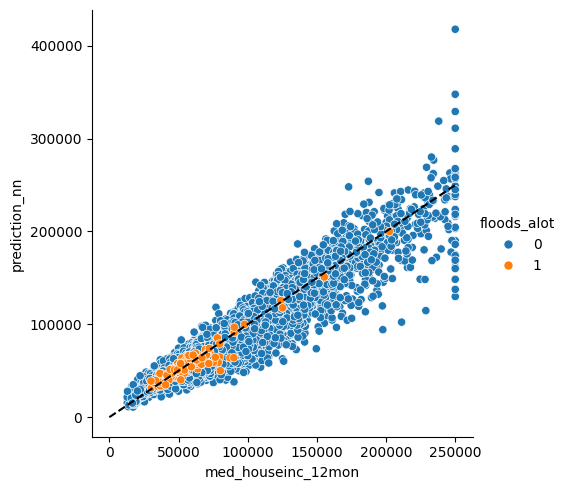

In [546]:

sns.relplot(data=df_census_predict.sort_values('floods_alot'), x=target, y='prediction_nn', hue='floods_alot')
# sns.relplot(data=df_census_predict.loc[df_census_predict['floods_alot']==1, :], x='med_houseinc_12mon', y='prediction', ax=ax)

# plt.plot([0.25, 0.75], [0.25, 0.75], linestyle='--', color='k')
plt.plot([0, 250000], [0, 250000], linestyle='--', color='k')